In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
from glob import glob
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from bayes_opt import BayesianOptimization

In [38]:
path_train = 'datacsv/k62/train/*.csv'
train_files = glob(path_train)

path_test = "datacsv/k62/test/*.csv"
test_files = glob(path_test)


In [4]:
def concat_dataset(files):
    li = []
    for filename in files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    dataFrame = pd.concat(li, axis=0, ignore_index=True)
    return dataFrame

In [39]:
df_train = concat_dataset(train_files)
df_test = concat_dataset(test_files)
print(df_train)

                AC         AT          Day1          Day2             EV  \
0     25566.000000   2.333333  42437.333333  42507.333333   25706.000000   
1     71965.000000   5.466667  42507.333333  42601.333333   72448.000000   
2     91166.000000   7.000000  42601.333333  42647.333333   90243.000000   
3    112485.000000   8.500000  42647.333333  42692.333333  113475.000000   
4    163189.000000  11.779167  42692.333333  42790.708333  162472.000000   
..             ...        ...           ...           ...            ...   
942  435364.159482  33.366667  41428.333333  41456.333333  371875.842480   
943  438741.660275  34.533333  41456.333333  41491.333333  375253.343054   
944     745.000000   0.152778           NaN           NaN            NaN   
945    1595.000000   0.386111           NaN           NaN            NaN   
946    1780.000000   0.519444           NaN           NaN            NaN   

                PV       TOTAL_AC   TOTAL_AT       TOTAL_EV       TOTAL_PV  \
0     396

In [74]:
features = ["XT", "AC"]
label = ["TOTAL_AC"]


In [60]:
def bayes_parameter_opt_lgb(X, y, init_round=20, opt_round=30, n_folds=5, random_seed=6, n_estimators=10000,
                            learning_rate=0.05, output_process=False):
    # prepare data

    train_data = lgb.Dataset(data=X, label=y)
    # parameters

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth,
                 lambda_l1, lambda_l2, min_split_gain, min_child_weight):

        params = {'objective': 'regression', 'num_iterations': 1000, 'learning_rate': 0.05,
                  'early_stopping_round': 100, 'metric': 'rmse'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight

        cv_result = lgb.cv(params, train_data, nfold=3, seed=random_seed,
                           stratified=False, verbose_eval=200, metrics=['rmse'])

        return min(cv_result['rmse-mean'])

    # setting range of the parameters
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 128),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 10),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 60)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    # output optimization process
    if output_process == True:
        lgbBO.points_to_csv("bayes_opt_result.csv")

    # return
    return lgbBO

In [8]:
# Thông tin test
y_test_ward = np.concatenate((y_test, np.array([0])))
count_test = 0
len_of_test = np.array([])
tmp = 1
for element in range(len(y_test_ward) - 1):
    if y_test_ward[element] != y_test_ward[element + 1]:
        count_test = count_test + 1
        len_of_test = np.concatenate((len_of_test, np.array([tmp])))
        tmp = 1
    else:
        tmp = tmp + 1
start_of_test = np.array([0])
for element in range(1, count_test):
    start_of_test = np.concatenate((start_of_test, np.array([ len_of_test[element - 1] + start_of_test[element - 1] ])))
print('count_test:')
print(count_test)
print('len_of_test:')
print(len_of_test)
print('start_of_test:')
print(start_of_test)

count_test:
39
len_of_test:
[ 10.  13.  24.  13.  29.  19.  14.  13.  36.  41.   7.  28.   9.   9.
   9.   8.   5.  10.   2.   5.  41.   6.  13.   6.   5.  18.   8.  23.
 120.  17.   5.   5.  18.  11.   9.  31.  20.  30.  11.]
start_of_test:
[  0.  10.  23.  47.  60.  89. 108. 122. 135. 171. 212. 219. 247. 256.
 265. 274. 282. 287. 297. 299. 304. 345. 351. 364. 370. 375. 393. 401.
 424. 544. 561. 566. 571. 589. 600. 609. 640. 660. 690.]


In [70]:
# from joblib import dump
# params = {"objective": "regression",
#               "metric": "rmse",
#               "bagging_frequency": 5,
#               "bagging_seed": 2018,
#               "verbosity": 0,

#               # Selected rounded-off params
#               'bagging_fraction': 0.7,
#               'feature_fraction': 1,
#               'lambda_l1': 1,
#               'lambda_l2': 0,
#               'max_depth': 9,
#               'min_child_weight': 20,
#               'min_split_gain': 0,
#               'num_leaves': 24}
params = bayes_parameter_opt_lgb(df_train[features], df_train[label], init_round=5, opt_round=10, n_folds=5,
                                     random_seed=6, n_estimators=10000, learning_rate=0.05)
params = params.max['params']
print(params)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print('y_true:')
    print(y_true)
    print('y_pred:')
    print(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

BM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [64]:
# params = {"bagging_fraction": 0.6, "feature_fraction": 0.7, "lambda_l1": 4, "lambda_l2": 2,"max_depth": 9, "min_child_weight": 53,  "min_split_gain": 0, "num_leaves": 103, "metric" : "rmse"}

# params = {
#     "objective" : "regression",
#     "metric" : "rmse",
#     "bagging_frequency" : 5,
#     "bagging_seed" : 2018,
#     "verbosity" : -1,

#     # Selected rounded-off params
#     'bagging_fraction': 0.7,
#     'feature_fraction': 0.5,
#     'lambda_l1': 1,
#     'lambda_l2': 0,
#     'max_depth': 9,
#     'min_child_weight': 5,
#     'min_split_gain': 0,
#     'num_leaves': 25
# }

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
stratified = False
num_folds = 5
if stratified:
        folds = StratifiedKFold(
            n_splits=num_folds, shuffle=True, random_state=50)
else:
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=50)
    # features = ["AT", "XT", "AC"]
    # label = "TOTAL_AC"
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train[label])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train[label].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train[label].iloc[valid_idx]
    print("train_x", train_x)
    print("valid_x", valid_x)

    gbm = LGBMRegressor(**params)

    gbm.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                early_stopping_rounds=130)

    oof_preds[valid_idx] = gbm.predict(
            valid_x, num_iteration=gbm.best_iteration_)
    sub_preds += gbm.predict(df_test[features],
                                 num_iteration=gbm.best_iteration_) / folds.n_splits
    print(sub_preds)
    print('Fold %2d MSE : %.6f' %
              (n_fold + 1, mean_squared_error(valid_y, oof_preds[valid_idx])))
    del gbm, train_x, train_y, valid_x, valid_y
print(
100 - mean_absolute_percentage_error(df_test[label]))


018e+06  4.68643712e+06  2.72257174e+06
  1.82789106e+07  1.80057166e+07  1.80057166e+07  1.80057166e+07
  1.80057166e+07  1.80057166e+07  1.75802859e+07  1.66755648e+07
  1.55062733e+07  1.55062733e+07  1.45416847e+07  1.42526449e+07
  1.37685020e+07  1.37685020e+07  1.37685020e+07  1.09552089e+07
  9.98937081e+06  9.93872248e+06  9.50514876e+06  7.98904487e+06
  8.00286631e+06  8.00286631e+06  8.01182029e+06  7.19588754e+06
  8.32158119e+06  8.32158119e+06  8.32158119e+06  9.80541136e+06
  9.80541136e+06  9.21630927e+06  1.14002912e+06  8.20215533e+05
  1.17589274e+06  2.80443046e+05  8.60589789e+05  1.21622495e+06
 -3.30120253e+05  2.34155585e+06  4.97340115e+06  5.06805078e+06
  3.07411958e+06]
Fold  4 MSE : 26300966855483.406250
train_x            XT             AC         AT
1    0.445911   71965.000000   5.466667
2    0.555437   91166.000000   7.000000
3    0.698428  112485.000000   8.500000
5    0.233945  194758.989258   0.933333
6    0.396776  330315.308350   2.100000
..      

             Day1          Day2
0    42437.333333  42507.333333
1    42507.333333  42601.333333
2    42601.333333  42647.333333
3    42647.333333  42692.333333
4    42692.333333  42790.708333
..            ...           ...
942  41428.333333  41456.333333
943  41456.333333  41491.333333
944           NaN           NaN
945           NaN           NaN
946           NaN           NaN

[947 rows x 2 columns]


In [65]:
# params = {"bagging_fraction": 1, "feature_fraction": 0.4, "lambda_l1": 1, "lambda_l2": 0,"max_depth": 8, "min_child_weight": 56,  "min_split_gain": 0, "num_leaves": 33, "metric" : "rmse", "learning_rate": 1}
params = {"bagging_fraction": 0.6, "feature_fraction": 0.7, "lambda_l1": 4, "lambda_l2": 2,"max_depth": 9, "min_child_weight": 53,  "min_split_gain": 0, "num_leaves": 103, "metric" : "rmse"}
gbm = LGBMRegressor(**params)
gbm.fit(df_train[features], df_train[label], eval_set=[(df_train[features], df_train[label]), (df_test[features], df_test[label])], early_stopping_rounds=200)
oof_preds = gbm.predict(
            df_test[features], num_iteration=gbm.best_iteration_)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[1]	valid_0's rmse: 8.29477e+06	valid_1's rmse: 1.79253e+07
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 7.80974e+06	valid_1's rmse: 1.77138e+07
[3]	valid_0's rmse: 7.40945e+06	valid_1's rmse: 1.75422e+07
[4]	valid_0's rmse: 7.04726e+06	valid_1's rmse: 1.73941e+07
[5]	valid_0's rmse: 6.77303e+06	valid_1's rmse: 1.72509e+07
[6]	valid_0's rmse: 6.50096e+06	valid_1's rmse: 1.7145e+07
[7]	valid_0's rmse: 6.27004e+06	valid_1's rmse: 1.70573e+07
[8]	valid_0's rmse: 6.09728e+06	valid_1's rmse: 1.6972e+07
[9]	valid_0's rmse: 

In [71]:
mean_absolute_percentage_error(df_test[label], abs(oof_preds))

868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [   75468.29867792]
 [   75468.29867792]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  494947.71251595]
 [  494947.712515

973.8442083392871

In [82]:
from sklearn.model_selection import GridSearchCV


parameters = {}
parameters['base_score'] = [0.5]
parameters['colsample_bylevel'] = [1]
parameters['colsample_bynode'] = [1]
parameters['colsample_bytree'] = [1]
parameters['gamma'] = [0, 1]
parameters['importance_type'] = ['gain']
parameters['learning_rate'] = [0.1, 0.09, 0.05, 0.01]
parameters['max_delta_step'] = [0]
parameters['max_depth'] = [7,8,9,10]
parameters['missing'] = [None]
parameters['n_estimators'] = [100, 1000]
parameters['n_jobs'] = [1]
parameters['nthread'] = [None]
parameters['objective'] = ['regression']
parameters['random_state'] = [0]
parameters['reg_alpha'] = [0]
parameters['reg_lambda'] = [1]
parameters['scale_pos_weight'] = [1]
parameters['seed'] = [None]
parameters['silent'] = [None]
parameters['subsample'] = [1, 0.8, 0.9]
parameters['verbosity'] = [-1]
parameters["metric"] = ["rmse"]
parameters["min_child_weight"] = [5,6,7]
parameters["num_leaves"] = [25,26,27]
gbm = LGBMRegressor()
# Create the grid
grid = GridSearchCV(gbm, parameters,
                    cv = 2,
                        n_jobs = 5,
                        verbose = True)

grid.fit(df_train[features], df_train[label],
             eval_set = [(df_train[features], df_train[label]), (df_test[features], df_test[label])],
             early_stopping_rounds = 100,
             verbose=True)
# print ra điểm tốt nhất


# lưu model để sau dùng

id_0's rmse: 1.80143e+06	valid_1's rmse: 1.04037e+07
[23]	valid_0's rmse: 1.73712e+06	valid_1's rmse: 1.03145e+07
[24]	valid_0's rmse: 1.65668e+06	valid_1's rmse: 1.02334e+07
[25]	valid_0's rmse: 1.58916e+06	valid_1's rmse: 1.01636e+07
[26]	valid_0's rmse: 1.53038e+06	valid_1's rmse: 1.01004e+07
[27]	valid_0's rmse: 1.47576e+06	valid_1's rmse: 1.00361e+07
[28]	valid_0's rmse: 1.41599e+06	valid_1's rmse: 9.98418e+06
[29]	valid_0's rmse: 1.36471e+06	valid_1's rmse: 9.93953e+06
[30]	valid_0's rmse: 1.32426e+06	valid_1's rmse: 9.89629e+06
[31]	valid_0's rmse: 1.29373e+06	valid_1's rmse: 9.85511e+06
[32]	valid_0's rmse: 1.25353e+06	valid_1's rmse: 9.81963e+06
[33]	valid_0's rmse: 1.23124e+06	valid_1's rmse: 9.78874e+06
[34]	valid_0's rmse: 1.19976e+06	valid_1's rmse: 9.74754e+06
[35]	valid_0's rmse: 1.17391e+06	valid_1's rmse: 9.71218e+06
[36]	valid_0's rmse: 1.15112e+06	valid_1's rmse: 9.68015e+06
[37]	valid_0's rmse: 1.12952e+06	valid_1's rmse: 9.65934e+06
[38]	valid_0's rmse: 1.1091e+06	

NameError: name 'xgb_grid' is not defined

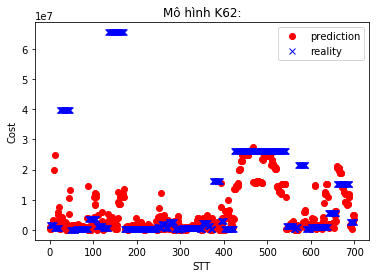

In [73]:
import matplotlib.pyplot as plt

plt.plot(abs(oof_preds), 'o', color = 'r')
plt.plot(df_test[label], 'x', color = 'b')
plt.title("Mô hình K62:")
plt.xlabel("STT")
plt.ylabel("Cost")

plt.legend(('prediction', 'reality'), loc = 'upper right')

plt.show()

In [84]:
print('xgb_grid.best_score_:')
print(grid.best_score_)

# print ra params tốt nhất
print('xgb_grid.best_params_:')
print(grid.best_params_)
dump(grid, "train_TOTAL_AC.dat")

xgb_grid.best_score_:
0.7370061056842448
xgb_grid.best_params_:
{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'metric': 'rmse', 'min_child_weight': 5, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': None, 'num_leaves': 25, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': -1}


['train_TOTAL_AC.dat']

In [87]:
from joblib import load
loaded_model = load("train_TOTAL_AC.dat")
preds = loaded_model.predict(df_test[features])
print(mean_absolute_percentage_error(df_test[label], abs(preds)))

 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [ 1868796.28351921]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [  646473.6460228 ]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2590796.72607422]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [ 2563675.86425781]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [  186107.00029945]
 [   75468.29867792]
 [   75468.29867792]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  180485.27005615]
 [  494947.71251595]
 [  494947.71251595]
 [  494947.7125